# Spatial averaged vector autoregressive (SAVAR) model 

SAVAR is a spatio-temporal model where some regions, the so-called modes, affect each other according to some underlying causal model. Modes are regions with covariant noise. We name components to the weighted average of the modes that affect the value of other modes in future time-steps. 

The model is given by the following expression: 

$$
	y_t^\ell:= \sum_{j=1}^{N}u^{\ell j}\sum_{i=1}^{N}\sum_{\tau=1}^{\tau_{max}}\phi^{ji}(\tau)\sum_{\ell}^{L}w^{i \ell} y_{t-\tau}^\ell+\epsilon^\ell_t
$$

where $y_t^\ell$ is the value of the random variable $y$ at time $t$ at location $\ell$, $u^{\ell j}$ is the coefficient that relates how the $j$-th component contributes to the value of $y^\ell_t$, $\phi^{ji}(\tau)$ is the contribution to the $i$-th component to the $j$-th component at time lag $\tau$, $w^{i\ell}$ is the coefficient that relates how $y^\ell$ contributes to the $i$-th and $\epsilon_t^\ell$ stands for a a noise term where $\epsilon_t^\ell \sim \mathcal{N}(\mu, \Sigma)$ and $\Sigma \in \mathbb{R}^{L\times L}$ is the correlation matrix.

the matrix form is given by

$$
	\mathbf{y}_t = W^+\sum_{\tau=1}^{\tau_{max}}\Phi(\tau) W \mathbf{y}_{t-\tau}+\mathbf{\epsilon}_t
$$

where $\mathbf y^T_t = (y^1_t, \dots, y^L_t)$, $u^{\ell j} \in W^+$, $\phi^{i j}(\tau)\in \Phi(\tau)$, $w^{i\ell} \in W$ and $\epsilon_t^\ell \in \mathbf \epsilon_t$. The matrix $W^+$ is the Moore-Penrose pseudoinvers of $W$. This is, $WW^+W=W$.


In [52]:
# Important, remember to install savar with `python setup.py isntall`
import spatial_models as models
import matplotlib.pyplot as plt
from functions import create_random_mode, check_stability
from c_functions import deseason_data, standardize_data
from c_dim_methods import get_varimax_loadings_standard as varimax

import numpy as np

In [53]:
# Some definitions

nx = 30  
ny = 90 # Each component is 30x30
T = 5000 # Time 

In [54]:
# Setup spatial weights of underlying processes

N = 3 # Three components

noise_weights = np.zeros((N, nx, ny))
modes_weights = np.zeros((N, nx, ny))

# This is an important parameter allows us to identify the modes because the covariance noise at grid level.
spatial_covariance = 10 

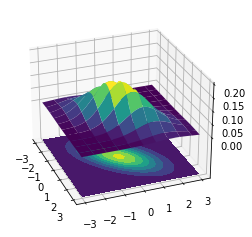

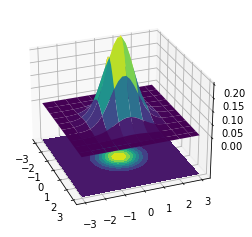

In [55]:
# There is a function to create random  modes 
_ = create_random_mode((30, 30), plot=True, random = True)

# If no random X is independent of y
_ = create_random_mode((30, 30), plot=True, random = False)

In [56]:
# We can create the modes with it.
noise_weights = np.zeros((N, nx, ny))
noise_weights[0, :, :30] = create_random_mode((30, 30), random = False)  # Random = False make modes round.
noise_weights[1, :, 30:60] = create_random_mode((30, 30), random = False)
noise_weights[2, :, 60:] = create_random_mode((30, 30), random = False)

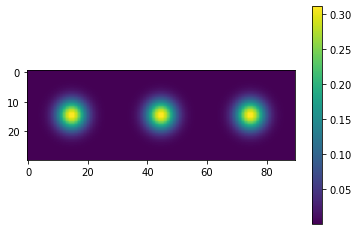

In [58]:
# How the modes look like
plt.imshow(noise_weights.sum(axis=0))
plt.colorbar()

With them, we define $\Sigma$. But is it also necessary to define $W$. This is, how we average this mode to influence other modes, according to an underlying VAR(p) process. This process is determined by $\Phi$ which we introduce in the same way as Tigramite.

In [59]:
# We can use the same
modes_weights = noise_weights

# And the causal model
links_coeffs = {
    0: [((0, -1), 0.5), ((2, -2), -0.2)],
    1: [((1, -1), 0.5), ((0, -1), 0.2)],
    2: [((2, -1), 0.5), ((1, -1), 0.2)]
}

# One good thing of SAVAR is that if the underlying process is stable and stationary, then SAVAR is also both. 
# Independently of W. This is, we only need to check for stationarity of \PHI and not of W^+\PHI W
check_stability(links_coeffs)

Start...
Compute values in time...
Done...
Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.14 of variance
	 Varimax rotation
	 Further metrics


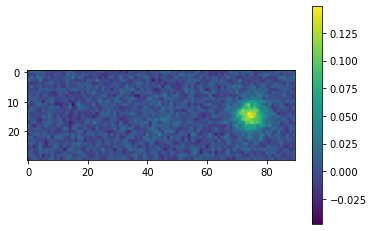

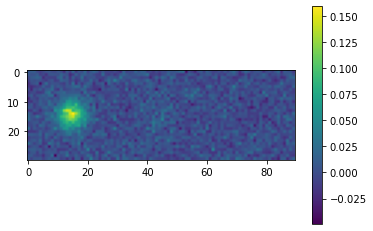

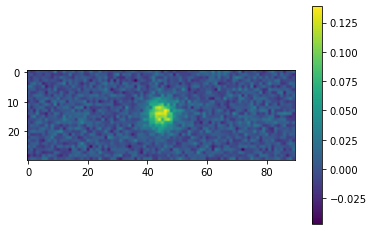

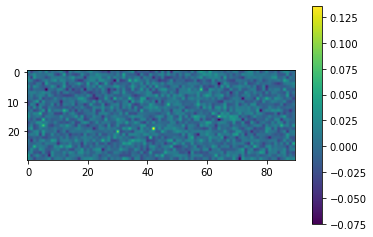

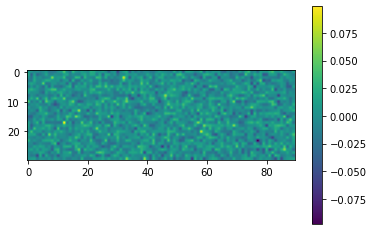

In [87]:
spatial_covariance = 10
savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=1000,
    spatial_covariance=spatial_covariance,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = True
)

savar.create_savar_data()  # After declaring the object we must generate the data.
modes = varimax(savar.data_field)  # Use variamx to try to recover the weights
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

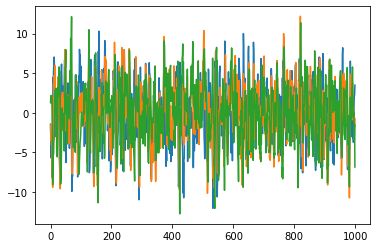

In [88]:
# We can print the modes together
savar.plot()

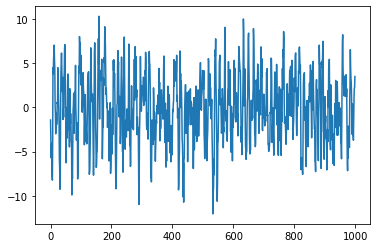

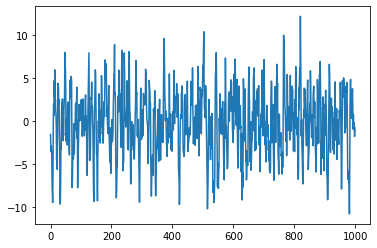

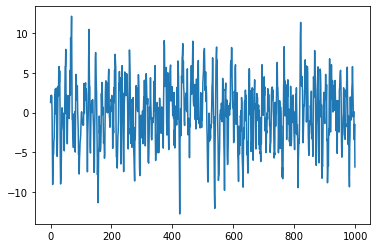

In [89]:
# Or independently
for i in range(3):
    plt.plot(savar.network_data[:, i])
    plt.show()

### Model generator

There is a module for randomly generate models. It is useful for experimetns. 

In [94]:
from model_generator import generate_savar_model

Start...
Compute values in time...
Done...
Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.15 of variance
	 Varimax rotation
	 Further metrics


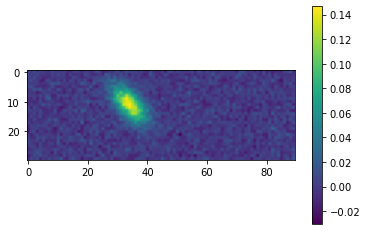

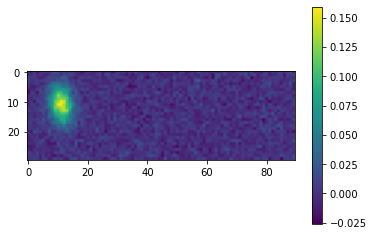

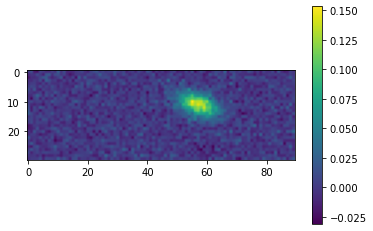

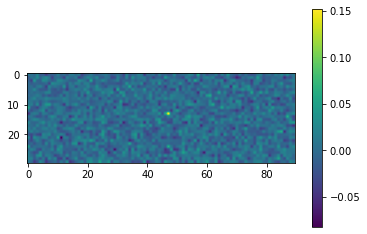

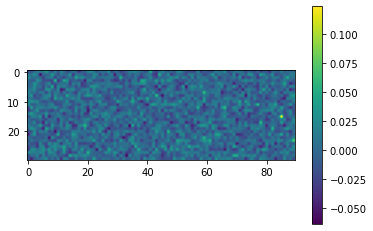

In [101]:
resolution = (30, 90)  # Total resolution
N = 3  # total number of modes
savar = generate_savar_model(n_variables=N,
                             time_length = 1000,
                             resolution=resolution, 
                             spatial_covariance=0.5, 
                             variance_noise=10)
savar.create_savar_data()
modes = varimax(savar.data_field)  # Use variamx to try to recover the weights
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

### Non linear data

SAVAR supports **EXPERIMENTALY** non-linear interactions. The list of non-linear functions is availible at the code. 

In [75]:
links_coeffs = {
    0: [((0, 1), 0.5, "linear"), # Linear autocorrelation
        ((2, 2), -0.4, "f2")],  # Non-linear autocorrelation
    1: [((1, 1), 0.5, "linear"), 
        ((0, 1), 0.4, "f2")],
    2: [((2, 1), 0.5, "linear"),
        ((1, 1), 0.4, "f2")]
}

In [80]:
savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=1000,
    spatial_covariance=10,
    noise_weights=noise_weights,
    lineartiy = "nonlinear",
    transient = 200, 
    n_variables = N,
    verbose = True
)

In [90]:
savar.create_savar_data()

Start...
Compute values in time...
Done...


Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 0.14 of variance
	 Varimax rotation
	 Further metrics


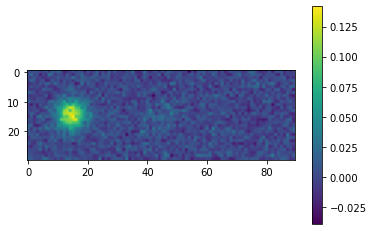

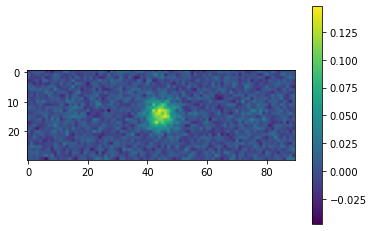

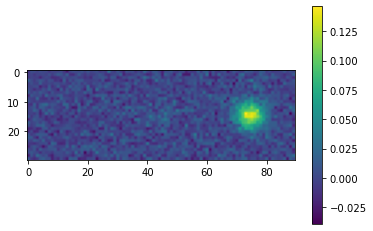

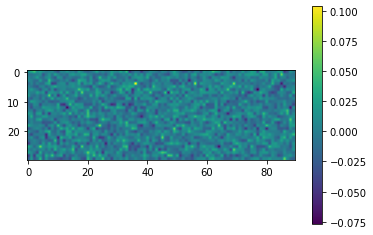

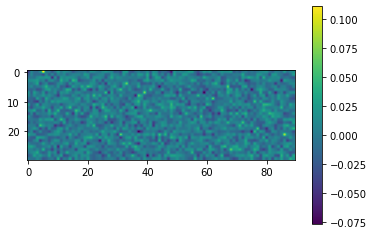

In [91]:
from c_dim_methods import get_varimax_loadings_standard as varimax
modes = varimax(savar.data_field)
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

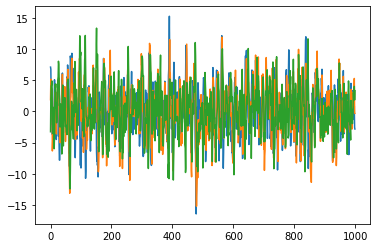

In [92]:
savar.plot()